# Data Explorations given external csv files

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os

In [91]:
bv = pd.read_csv("../references/external/bill_version.csv", sep=";", encoding="latin1", parse_dates=True)
sessions =  pd.read_csv("../references/external/session.csv", sep=";", encoding="latin1", parse_dates=True)
bills =  pd.read_csv("../references/external/bill.csv", sep=";", encoding="latin1", parse_dates=True)
divs =  pd.read_csv("../references/external/division.csv", sep=";", encoding="latin1", parse_dates=True)
bill_leg_vote =  pd.read_csv("../references/external/bill_legislator_vote.csv", sep=";", encoding="latin1", parse_dates=True)
vote_rec_type =  pd.read_csv("../references/external/vote_recorded_type.csv", sep=";", encoding="latin1", parse_dates=True)

In [92]:
if 'DATA_VOL' not in os.environ:
    # Manually set:
    DATA_VOL = '/home/luke/datavol/'
else:
    DATA_VOL = os.environ['DATA_VOL']
print(DATA_VOL)
version_exists = []
for i in bv['id']:
    fn = DATA_VOL + 'clean/' + str(i) + '.txt'
    #print(fn)
    if os.path.exists(fn):
        version_exists.append(True)
    else:
        version_exists.append(False)
print(len(bv))
print(sum(version_exists))
bv = bv[version_exists]

/home/luke/datavol/
615357
615357


In [93]:
# Data Cleaning:
# One bill version has no bill_id
bills = bills[~bills.chamber_id.isna()]
bills.chamber_id = bills.chamber_id.astype(int)


for col in bills[['signed', 'passed_lower', 'passed_upper' ]]:
    mask = bills[col].isna()
    bills.loc[mask, col] = 0
    mask = bills[col]!=0
    bills.loc[mask, col] = 1

In [94]:
divs.head()

,id,identifier,name,abbr,has_data,division_type_id,division_level_id,same_as,parent_id,valid_through,valid_from,thread_id,timezone_id
0,651,ocd-division/country:us/state:ak,Alaska,AK,1,10,1,NaN,1.0,NaN,NaN,1,54.0
1,1421,ocd-division/country:us/state:al,Alabama,AL,1,10,1,NaN,1.0,NaN,NaN,1,88.0
2,4979,ocd-division/country:us/state:ar,Arkansas,AR,1,10,1,NaN,1.0,NaN,NaN,1,88.0
3,193348,ocd-division/country:us/territory:as,American Samoa,AS,0,35,1,NaN,1.0,NaN,NaN,1,NaN
4,9178,ocd-division/country:us/state:az,Arizona,AZ,1,10,1,NaN,1.0,NaN,NaN,1,164.0


Asks from Tim:

* Political control of each chamber.
* states corresponding to each state_id
* Chamber_id? 1=Lower, 2=Upper?


# Bill Versions

id: primary key
name: Captured name text from original source
mimetype: content type
url: S3 location after hashing
bill_id: foreign key to the bills table

# Bills

id: primary key
chamber_id: 1=house, 2=senate
session_id: foreign key to chamber table
division_id: State/territory id
passed_upper: boolean (also missing)
passed_lower: boolean (also missing)
signed: boolean (also missing)

# Sessions

id: primary key
division_id: State/territory id
in_session: boolean, is session done yet

# Division

id: primary key
abbr: state abbreviation


Interesting questions and TODOS:

* How many unique bills are there?
* What time frame are we dealing with?
* What state has the most/least bills?
* What state passed the most legislation?
* Get a story together about the versioning process
* 

* 53 jurisdictions. created_at runs from 2018-2020

-- 247,565 unique bills
-- What is state_id = 53 with very very few bills passed.

In [95]:
# Number of unique bills per state. How many passed each chamber.
df = bills.merge(divs, left_on="division_id", right_on="id")
df[['abbr', "signed", "passed_upper", "passed_lower", "has_data"]].groupby("abbr").agg(["count"]).sort_values('abbr').head()

,signed,passed_upper,passed_lower,has_data
,count,count,count,count
abbr,,,,
AK,664,664,664,664
AL,2421,2421,2421,2421
AR,2037,2037,2037,2037
AZ,2997,2997,2997,2997
CA,5388,5388,5388,5388


In [96]:
df = df[['abbr', 'passed_lower', 'passed_upper', 'signed']]
df = df.fillna(0)
for col in df.columns[1:]:
    mask = df[col]!=0
    df.loc[mask, col] = 1
df = df.astype({"abbr":str, "signed": int, "passed_upper": int, "passed_lower":int})
passage_agg = df.groupby('abbr').agg(["mean", "count"])
#sm = passage_agg['signed']['count'].sort_values(axis=0)
sm = passage_agg['signed']['mean'].sort_values(axis=0)




In [97]:
# Calculate the version number of the bill.

# NOTES: Updated_at may potentialy be the same for each bill_id, we order by the id in this case
a = bv
a['version_number'] = a[['id', 'bill_id', 'updated_at']].groupby('bill_id').cumcount()+1
a[['id', 'bill_id', 'version_number', 'updated_at']].sort_values('bill_id').tail(n=100)

,id,bill_id,version_number,updated_at
615166,2743086,1347140,3,2020-08-07 20:47:51
615165,2743085,1347140,2,2020-08-07 20:47:51
615164,2743084,1347140,1,2020-08-07 20:47:50
615167,2743087,1347142,1,2020-08-07 20:48:01
615169,2743089,1347142,3,2020-08-07 20:48:03
...,...,...,...,...
615238,2743158,1347259,1,2020-08-08 02:16:56
615240,2743160,1347260,1,2020-08-08 02:17:07
615241,2743161,1347261,1,2020-08-08 02:17:20
615242,2743162,1347262,1,2020-08-08 02:17:30


In [98]:
a[['bill_id', 'name', 'id', 'version_number']].sort_values('version_number', ascending=False).head(n=100)

,bill_id,name,id,version_number
225855,1211737,"Section 15-18- Appropriations Clauses, Safety ...",2350546,223
225854,1211737,Section 14- FY 2018-19 Public Health & Environ...,2350545,222
225853,1211737,Section 13- FY 2018-19 Personnel (04/17/2019),2350544,221
225852,1211737,Section 12- FY 2018-19 Judicial (04/17/2019),2350543,220
225851,1211737,Section 11- FY 2018-19 Human Services (04/17/2...,2350542,219
...,...,...,...,...
210299,1211737,Natural Resources (04/05/2019),2334939,164
418463,1301160,995079 - Amendment to S 2500 Filed,2544386,164
557461,1337882,Law (06/12/2020),2685381,164
557460,1337882,Labor (06/12/2020),2685380,163


In [99]:
pl      = pd.read_csv("../references/derived/partisan_lean.csv", sep=",", encoding="latin1", parse_dates=True)
#doc_len = pd.read_csv("../notebooks/doc_len.csv")

In [100]:
ml_data = a[['id', 'version_number', 'bill_id']].merge(bills[['id', 'signed', 'session_id', 'passed_lower', 'passed_upper', 'chamber_id']].rename(columns={'id':"bill_id"}), on='bill_id')
ml_data = ml_data.merge(pl[['session_id', 'chamber_id', 'partisan_lean']], on=['session_id', 'chamber_id'])
ml_data = ml_data.fillna(0)


In [101]:
ml_data['passed'] = ml_data['passed_lower']*(ml_data['chamber_id']==1) + ml_data['passed_upper']*(ml_data['chamber_id']==2)
ml_data[ml_data.passed_lower==1]

,id,version_number,bill_id,signed,session_id,passed_lower,passed_upper,chamber_id,partisan_lean,passed
11,2127866,1,1098149,1,562,1,1,1,0.236118,1
14,2128986,1,1098872,1,562,1,1,1,0.236118,1
15,2128987,1,1098873,1,562,1,1,1,0.236118,1
16,2129001,1,1098887,1,562,1,1,1,0.236118,1
17,2129227,1,1099089,1,562,1,1,1,0.236118,1
...,...,...,...,...,...,...,...,...,...,...
496157,2676412,1,1339106,0,645,1,0,2,0.317073,0
496158,2676413,1,1339107,0,645,1,1,2,0.317073,1
496159,2676414,2,1339107,0,645,1,1,2,0.317073,1
496186,2607306,1,1330964,0,649,1,1,1,0.341463,1


In [102]:
ml_data['sc_id'] = ml_data['session_id'].astype(str) + "-" + ml_data['chamber_id'].astype(str)
ml_data = ml_data[['id', 'version_number', 'bill_id', 'signed', 'passed', 'partisan_lean',  'sc_id']]
pre_sample = ml_data

In [103]:
s1 = ml_data[['bill_id', 'id']].groupby('bill_id').sample(1)
ml_data = ml_data.merge(s1, on = ['id', 'bill_id'])

In [104]:
ml_data.head()

,id,version_number,bill_id,signed,passed,partisan_lean,sc_id
0,2119301,1,1092981,0,0,0.236118,562-1
1,2127866,1,1098149,1,1,0.236118,562-1
2,2127963,1,1098199,0,0,0.236118,562-1
3,2128334,1,1098465,0,0,0.236118,562-1
4,2128986,1,1098872,1,1,0.236118,562-1


In [106]:
#ml_data.to_csv('../references/derived/ml_data.csv', index=False)

In [ ]:
# df2 = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
# df2.head()

In [107]:
ml_data.head()

,id,version_number,bill_id,signed,passed,partisan_lean,sc_id
0,2119301,1,1092981,0,0,0.236118,562-1
1,2127866,1,1098149,1,1,0.236118,562-1
2,2127963,1,1098199,0,0,0.236118,562-1
3,2128334,1,1098465,0,0,0.236118,562-1
4,2128986,1,1098872,1,1,0.236118,562-1


In [108]:
ml_data.shape

(199646, 7)

In [109]:
import numpy as np
np.mean(ml_data.passed)

0.15937709746250864

In [110]:
np.mean(ml_data.signed)

0.13822465764402994

In [111]:
LabelEncoder().fit_transform(ml_data['sc_id'])

array([  6,   6,   6, ..., 133, 133, 133])

In [136]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

df_cat_x = LabelEncoder().fit_transform(ml_data['sc_id'])
categorical_features_indices = [0]
df_cat_y = ml_data['passed']
(X_train, X_test, Y_train, Y_test) = train_test_split(df_cat_x, df_cat_y, test_size=0.1, random_state=0)

model.fit(
    X_train.reshape([-1,1]), Y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, Y_test),
    plot=True
);
preds_cat_only = model.predict_proba(X_test.reshape([-1,1]))[:,1]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94     16771
           1       0.73      0.46      0.57      3194

    accuracy                           0.89     19965
   macro avg       0.82      0.72      0.75     19965
weighted avg       0.88      0.89      0.88     19965

[[16231   540]
 [ 1710  1484]]
N thresholds: 691


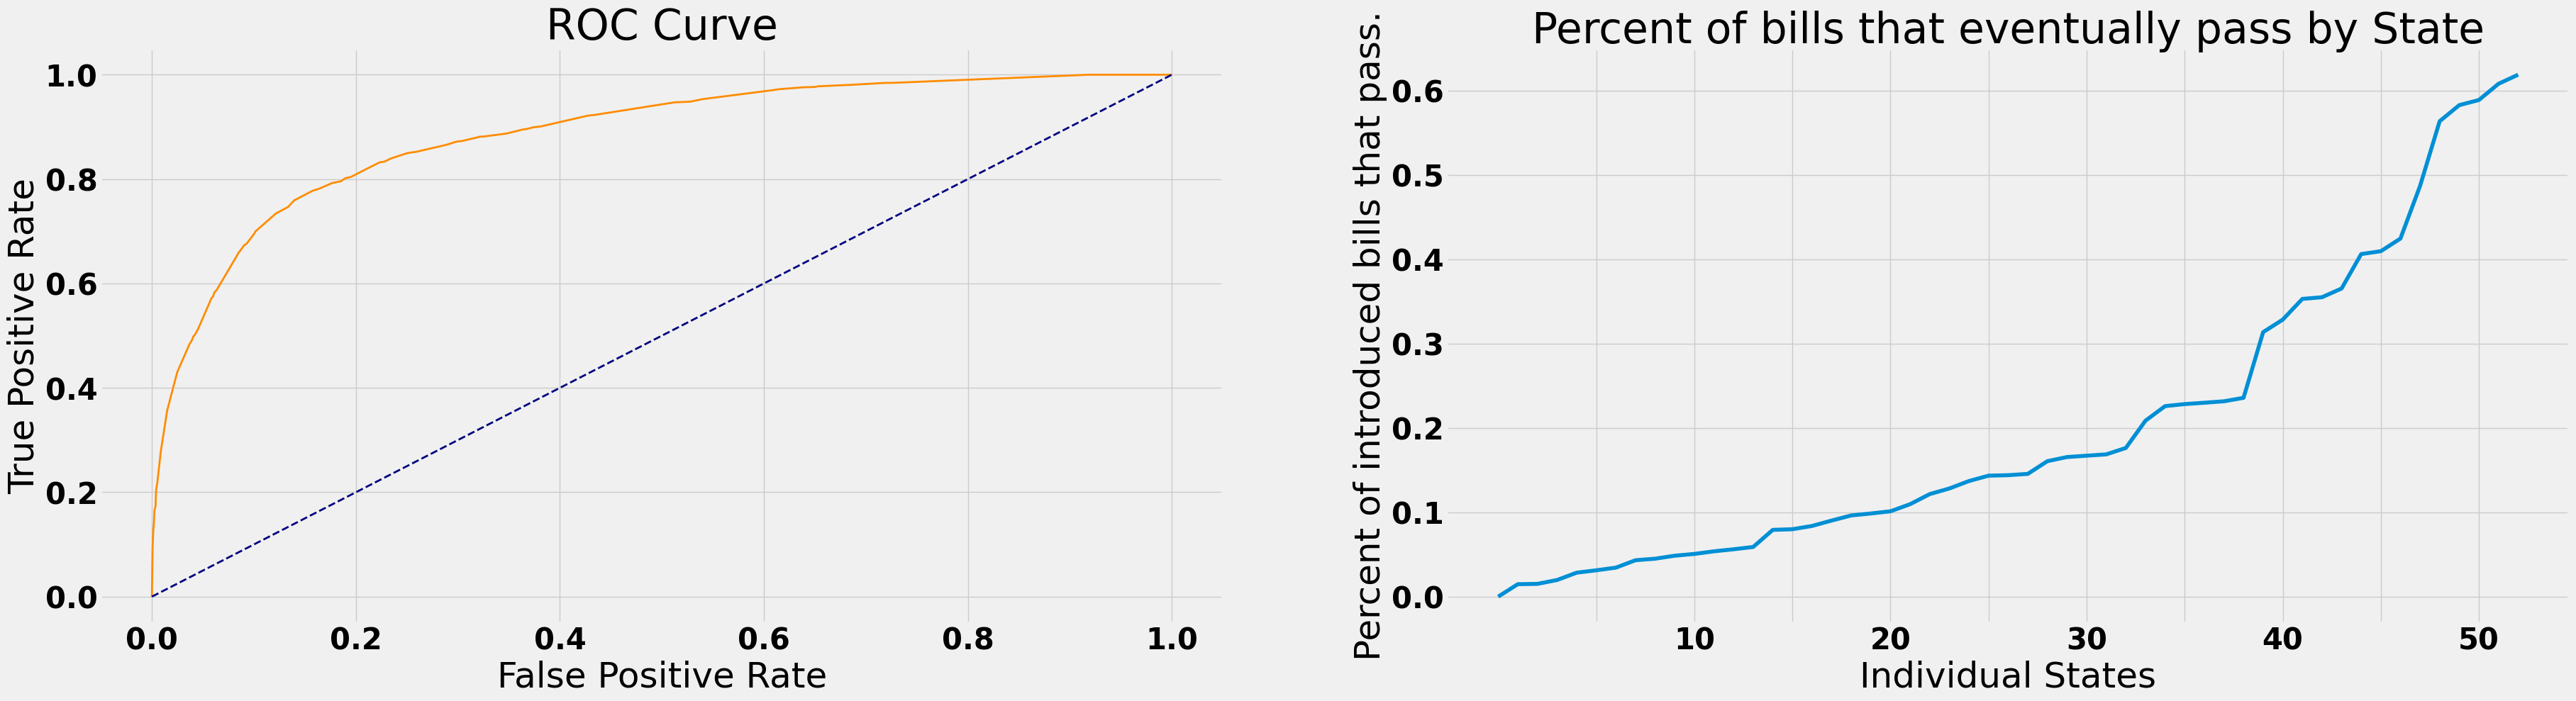

In [170]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.visualization.performance_metrics import print_performance_metrics

truth = Y_test.values
pred=preds_cat

cr = classification_report(truth, pred > 0.5)
print(cr)

print(confusion_matrix(truth, pred>0.5))

# plot ROC curve
fpr, tpr, thresholds = roc_curve(truth, pred, pos_label=1)

print(f"N thresholds: {len(thresholds)}")

roc_auc = roc_auc_score(truth, pred)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(fpr, tpr, color='darkorange',
     lw=2, label='ROC curve (area = %0.3f)' % roc_auc)


ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#ax1.xlim([0.0, 1.0])
#ax1.ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
#ax1.set_legend(loc="lower right")
#plt.show()



ax2.plot( range(len(sm)), sm.values)
#plt.xticks(ticks = [])
ticks = list(range(5,len(sm),5))
ax2.set_xticks(ticks)
#ax.set_xticklabels(sm.index.values)
#plt.label = 'xx'
ax2.set_title("Percent of bills that eventually pass by State")
ax2.set_xlabel("Individual States")
ax2.set_ylabel("Percent of introduced bills that pass.")
#fig.sup_title = ""

#matplotlib.rcParams['figure.figsize'] = [10,6]

# Thin the x-axis labels for visibility
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.savefig("passage_fraction_with_null_model_roc.png")
plt.show()


In [114]:
pl= pre_sample[['passed', 'version_number']].groupby('version_number').agg('mean').reset_index()

In [115]:
pl.head()

,version_number,passed
0,1,0.159377
1,2,0.207815
2,3,0.400195
3,4,0.495984
4,5,0.654607


In [123]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

ml_data['sc_id_cat'] = LabelEncoder().fit_transform(ml_data['sc_id'])
df_cat_x = ml_data[['sc_id_cat', 'version_number']]
categorical_features_indices = [0]
df_cat_y = ml_data['passed']
(X_train, X_test, Y_train, Y_test) = train_test_split(df_cat_x, df_cat_y, test_size=0.1, random_state=0)

model.fit(
    X_train, Y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, Y_test),
    plot=True
);
preds_cat = model.predict_proba(X_test)[:,1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

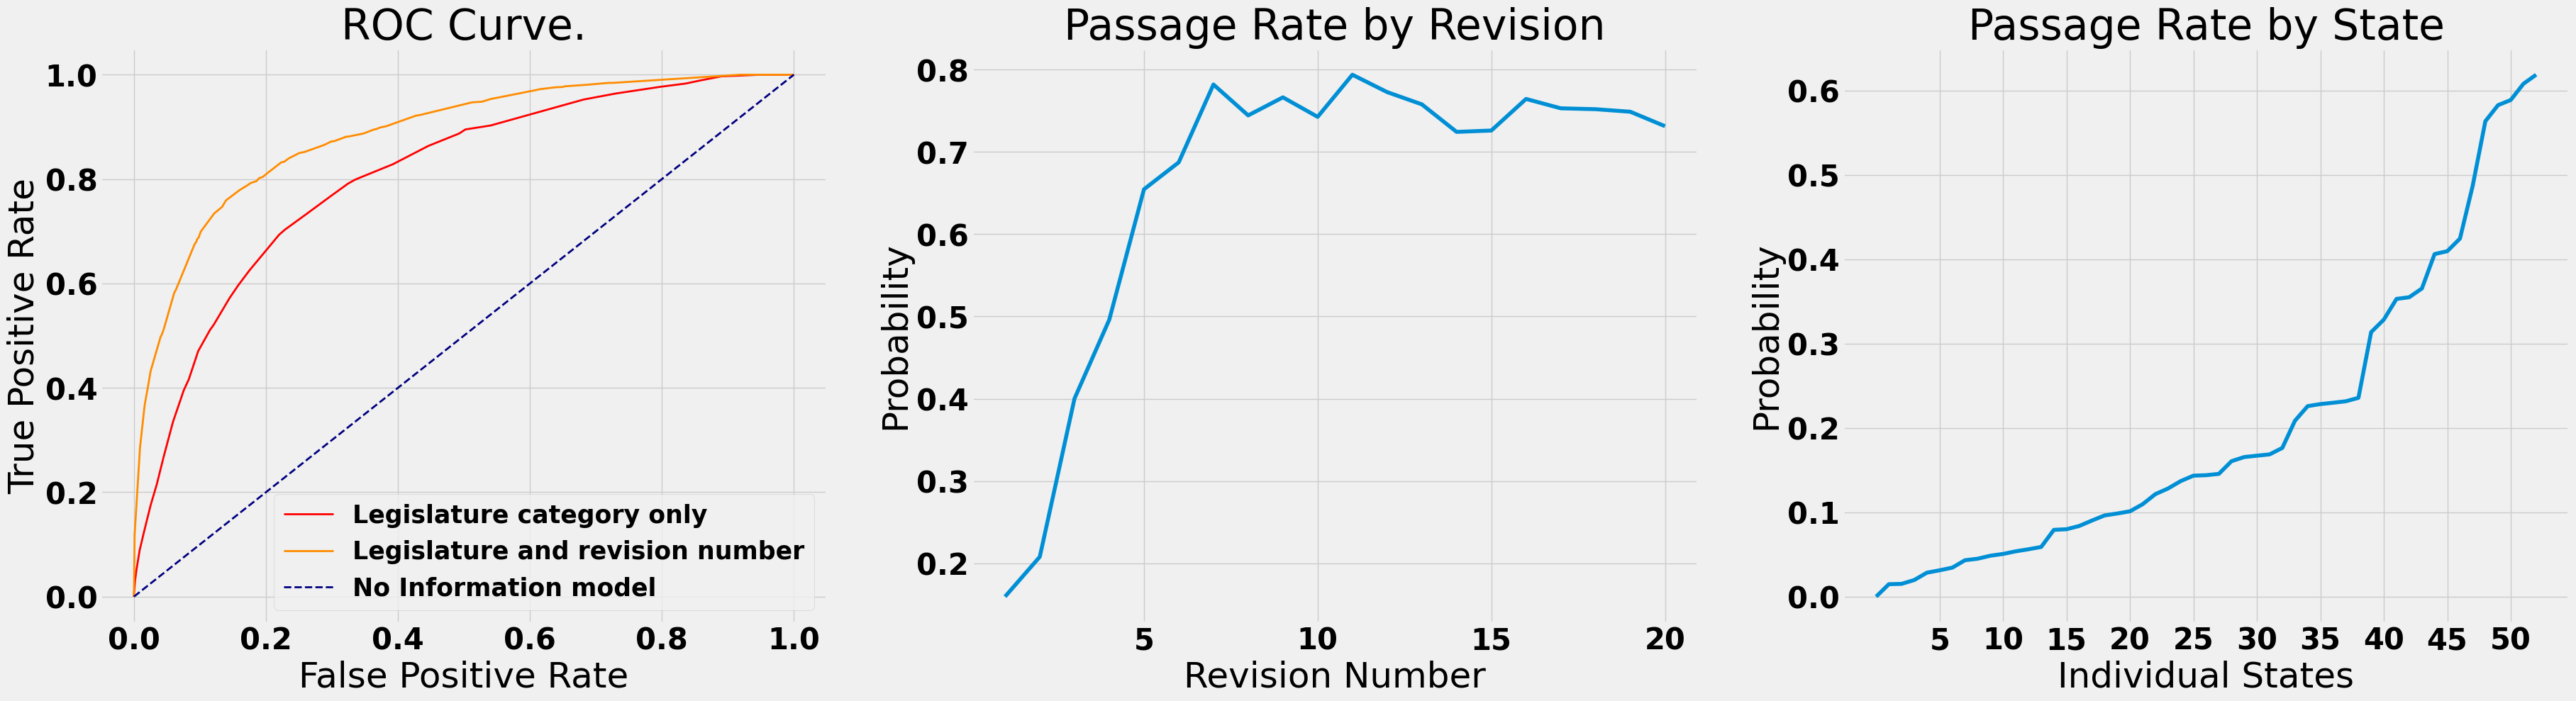

In [166]:
plt.style.use('fivethirtyeight')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

truth = Y_test.values
pred=preds_cat
fpr, tpr, thresholds = roc_curve(truth, pred, pos_label=1)

fpr0, tpr0, thresholds = roc_curve(truth, preds_cat_only, pos_label=1)
ax1.plot(fpr0, tpr0, color='red', lw=2)

ax1.plot(fpr, tpr, color='darkorange',
     lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#ax1.xlim([0.0, 1.0])
#ax1.ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve.')
ax1.legend(["Legislature category only", "Legislature and revision number", "No Information model"],
          loc = 'lower right', prop={'size': 25})

ax2.plot(pl.version_number[:20], pl.passed[:20])
ax2.set_xlabel('Revision Number')
ax2.set_ylabel('Probability')
ax2.set_title('Passage Rate by Revision')

ax3.plot( range(len(sm)), sm.values)
#plt.xticks(ticks = [])
ticks = list(range(5,len(sm),5))
ax3.set_xticks(ticks)
#ax.set_xticklabels(sm.index.values)
#plt.label = 'xx'
ax3.set_title("Passage Rate by State")
ax3.set_xlabel("Individual States")
ax3.set_ylabel("Probability")

matplotlib.rcParams['figure.figsize'] = [40,10]
plt.savefig("passage_fraction_with_null_model_roc.png", bbox_inches='tight')
plt.show()

In [169]:
sm.values[1]

0.014846743295019157